## 1. Import Library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import shutil

import os
import random
import numpy as np
from six import BytesIO
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPyImage

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [2]:
# CPU Optimizations 
tf.config.experimental.set_virtual_device_configuration(
    tf.config.experimental.list_physical_devices("CPU")[0],
    [tf.config.experimental.VirtualDeviceConfiguration()],
)

# GPU Memory Limit Optimization
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices("GPU")[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=10899)],
)

## 2. Data Preprocessing

In [3]:
# Load Train Dataset
df_train_raw = pd.read_csv('data/nutri_table/train.csv')

# Load necessary columns
df_train_filtered = df_train_raw[['image_id', 'table_bbox', 'category_name']]

# load data that only has category_name "['nutrition-table']" or "['nutrition-table-text']"
df_train_filtered = df_train_filtered[df_train_filtered['category_name'].apply(lambda x: x == '[\'nutrition-table\']' or x == '[\'nutrition-table-text\']')]
df_train_filtered = df_train_filtered.reset_index(drop=True)
df_train_filtered.info()
df_train_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       996 non-null    object
 1   table_bbox     996 non-null    object
 2   category_name  996 non-null    object
dtypes: object(3)
memory usage: 23.5+ KB


image_id                                         table_bbox  \
0     0009800892204_1  [array([0.05709876, 0.01427469, 0.60350156, 0....   
1     0024842112219_3  [array([0.15196079, 0.14705883, 0.5882353 , 0....   
2    3560070581849_11  [array([0.00833333, 0.01011561, 0.99444443, 0....   
3     0061954000539_4  [array([0.17181559, 0.3201923 , 0.625     , 0....   
4          25231656_1  [array([0.25124797, 0.14320119, 0.46832615, 0....   
..                ...                                                ...   
991   0041148813558_3  [array([0.4983365, 0.2798077, 0.6756179, 0.717...   
992        00975957_1  [array([0.29503676, 0.10866013, 0.4574142 , 0....   
993        00500241_4  [array([0.02152778, 0.00148049, 0.890625  , 0....   
994   0030100053149_2  [array([0.11917892, 0.30501089, 0.5661765 , 0....   
995        20436582_2  [array([0.10140932, 0.07843138, 0.4708946 , 0....   

                category_name  
0         ['nutrition-table']  
1         ['nutrition-table']  
2         ['nutrition-table']  
3         ['nutrition-table']  
4         ['nutrition-table']  
..                        ...  
991       ['nutrition-table']  
992  ['nutrition-table-text']  
993       ['nutrition-table']  
994       ['nutrition-table']  
995       ['nutrition-table']  

[996 rows x 3 columns]

In [4]:
# Load Validation Dataset
df_val_raw = pd.read_csv('data/nutri_table/val.csv')

# Load necessary columns
df_val_filtered = df_val_raw[['image_id', 'table_bbox', 'category_name']]

# load data that only has category_name "['nutrition-table']" or "['nutrition-table-text']"
df_val_filtered = df_val_filtered[df_val_filtered['category_name'].apply(lambda x: x == '[\'nutrition-table\']' or x == '[\'nutrition-table-text\']')]
df_val_filtered = df_val_filtered.reset_index(drop=True)
df_val_filtered.info()
df_val_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       115 non-null    object
 1   table_bbox     115 non-null    object
 2   category_name  115 non-null    object
dtypes: object(3)
memory usage: 2.8+ KB


image_id                                         table_bbox  \
0    0041129077641_1  [array([0.4871673 , 0.27339745, 0.64093405, 0....   
1    0070200581159_1  [array([0.24662991, 0.26552287, 0.45325696, 0....   
2    0064144043064_2  [array([0.10315078, 0.04094965, 0.51433176, 0....   
3    0051500700167_1  [array([0.31433877, 0.16432449, 0.8336485 , 0....   
4    0016447100951_1  [array([0.36299592, 0.35      , 0.6154987 , 0....   
..               ...                                                ...   
110  0071962226104_3  [array([0.34341377, 0.17637762, 0.8466305 , 0....   
111  0039000081047_4  [array([0.2526378 , 0.21890113, 0.6482843 , 0....   
112       26209142_6  [array([5.2012689e-04, 1.0787505e-02, 1.000000...   
113       20511586_3  [array([0.00419526, 0.2200406 , 0.9211625 , 0....   
114  0071921377601_1  [array([0.14981617, 0.0870098 , 0.5306235 , 0....   

           category_name  
0    ['nutrition-table']  
1    ['nutrition-table']  
2    ['nutrition-table']  
3    ['nutrition-table']  
4    ['nutrition-table']  
..                   ...  
110  ['nutrition-table']  
111  ['nutrition-table']  
112  ['nutrition-table']  
113  ['nutrition-table']  
114  ['nutrition-table']  

[115 rows x 3 columns]

In [5]:
# Create new directories: data/nutri_table_clean/train and data/nutri_table_clean/val
os.makedirs('data/nutri_table_clean/train', exist_ok=True)
os.makedirs('data/nutri_table_clean/val', exist_ok=True)

# Copy train and validation data to the new directory based on the filtered category_name
for idx, name in enumerate(df_train_filtered['image_id']):
    shutil.copy(
        os.path.abspath(f'data/nutri_table/train/{name}.jpg'),
        f'data/nutri_table_clean/train/{idx}.jpg',
    )
    
for idx, name in enumerate(df_val_filtered['image_id']):
    shutil.copy(
        os.path.abspath(f'data/nutri_table/val/{name}.jpg'),
        f'data/nutri_table_clean/val/{idx}.jpg',
    )

In [6]:
# Change image_id to index
df_train_filtered['image_id'] = df_train_filtered.index
df_val_filtered['image_id'] = df_val_filtered.index

In [7]:
# Export new csv to data/nutri_table_clean
df_train_filtered.to_csv('data/nutri_table_clean/train.csv', index=False)
df_val_filtered.to_csv('data/nutri_table_clean/val.csv', index=False)

## 3. Load Clean Dataset

In [3]:
# Load cleaned csv Train Dataset
df_train = pd.read_csv('data/nutri_table_clean/train.csv')
df_train.info()
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       996 non-null    int64 
 1   table_bbox     996 non-null    object
 2   category_name  996 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


image_id                                         table_bbox  \
0           0  [array([0.05709876, 0.01427469, 0.60350156, 0....   
1           1  [array([0.15196079, 0.14705883, 0.5882353 , 0....   
2           2  [array([0.00833333, 0.01011561, 0.99444443, 0....   
3           3  [array([0.17181559, 0.3201923 , 0.625     , 0....   
4           4  [array([0.25124797, 0.14320119, 0.46832615, 0....   
..        ...                                                ...   
991       991  [array([0.4983365, 0.2798077, 0.6756179, 0.717...   
992       992  [array([0.29503676, 0.10866013, 0.4574142 , 0....   
993       993  [array([0.02152778, 0.00148049, 0.890625  , 0....   
994       994  [array([0.11917892, 0.30501089, 0.5661765 , 0....   
995       995  [array([0.10140932, 0.07843138, 0.4708946 , 0....   

                category_name  
0         ['nutrition-table']  
1         ['nutrition-table']  
2         ['nutrition-table']  
3         ['nutrition-table']  
4         ['nutrition-table']  
..                        ...  
991       ['nutrition-table']  
992  ['nutrition-table-text']  
993       ['nutrition-table']  
994       ['nutrition-table']  
995       ['nutrition-table']  

[996 rows x 3 columns]

In [4]:
# Load cleaned csv Validation Dataset
df_val = pd.read_csv('data/nutri_table_clean/val.csv')
df_val.info()
df_val

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       115 non-null    int64 
 1   table_bbox     115 non-null    object
 2   category_name  115 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


image_id                                         table_bbox  \
0           0  [array([0.4871673 , 0.27339745, 0.64093405, 0....   
1           1  [array([0.24662991, 0.26552287, 0.45325696, 0....   
2           2  [array([0.10315078, 0.04094965, 0.51433176, 0....   
3           3  [array([0.31433877, 0.16432449, 0.8336485 , 0....   
4           4  [array([0.36299592, 0.35      , 0.6154987 , 0....   
..        ...                                                ...   
110       110  [array([0.34341377, 0.17637762, 0.8466305 , 0....   
111       111  [array([0.2526378 , 0.21890113, 0.6482843 , 0....   
112       112  [array([5.2012689e-04, 1.0787505e-02, 1.000000...   
113       113  [array([0.00419526, 0.2200406 , 0.9211625 , 0....   
114       114  [array([0.14981617, 0.0870098 , 0.5306235 , 0....   

           category_name  
0    ['nutrition-table']  
1    ['nutrition-table']  
2    ['nutrition-table']  
3    ['nutrition-table']  
4    ['nutrition-table']  
..                   ...  
110  ['nutrition-table']  
111  ['nutrition-table']  
112  ['nutrition-table']  
113  ['nutrition-table']  
114  ['nutrition-table']  

[115 rows x 3 columns]

In [5]:
# Load image data directory
BASE_DIR = 'data/nutri_table_clean/'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')

# Show number of images in train and vali directories
print(f'Train Images: {len(os.listdir(train_dir))}')
print(f'Validation Images: {len(os.listdir(val_dir))}')

Train Images: 996
Validation Images: 115


## 4. Convert bounding boxes object (string) into a numpy

In [17]:
# Convert String object on table_bbox column to numpy array float32
def bbox_convert_to_numpy(data):
    bbox_str = data.replace('[array([', '').replace(')]', '')
    bbox_str = bbox_str.replace(', dtype=float32', '').replace(',\n       dtype=float32)', '').replace('                                               ]', '')
    bbox_str = bbox_str.replace(']', '')
    return np.array([[float(x) for x in bbox_str.split(', ')]], dtype=np.float32)

# Create bbox_train and bbox_val that store numpy array float32
train_bbox = df_train['table_bbox'].apply(bbox_convert_to_numpy).tolist()
val_bbox = df_val['table_bbox'].apply(bbox_convert_to_numpy).tolist()

In [18]:
gt_boxes = train_bbox[:6]

## 5. Display the examples of the train data based on images path

In [ ]:
def load_image_into_numpy_array(path):

    img_data = tf.io.gfile.GFile(path, "rb").read()
    image = Image.open(BytesIO(img_data))
    if image.mode != "RGB":
        image = image.convert("RGB")
    (im_width, im_height) = image.size
    return np.array(image).reshape((im_height, im_width, 3)).astype(np.uint8)

In [15]:
# Load images and convert to numpy array
train_image_dir = 'data/nutri_table_clean/train'
train_images_np = []
for i in range(6):
  image_path = os.path.join(train_image_dir, str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

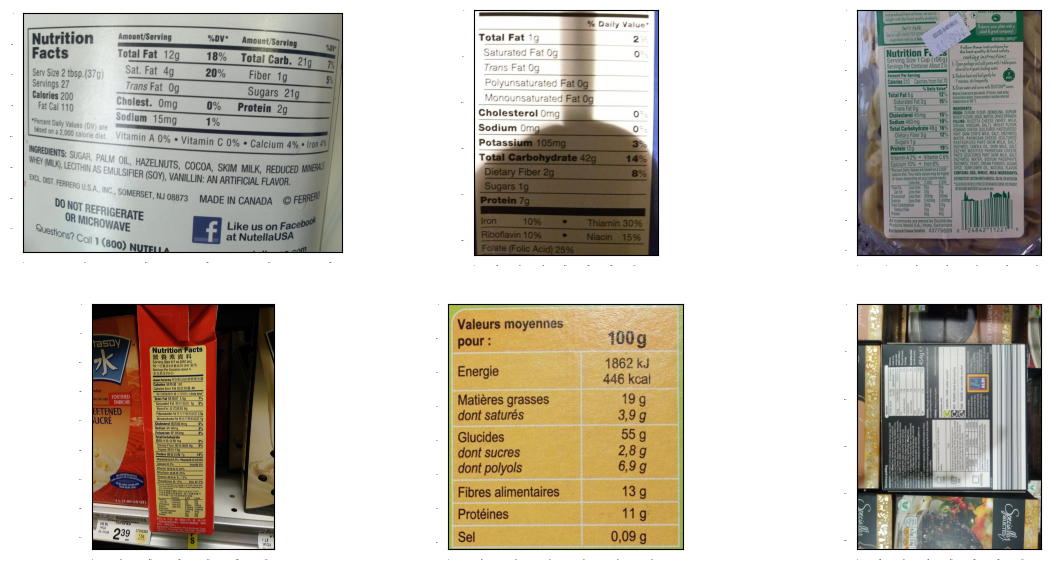

In [16]:
%matplotlib inline

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# Pilih 6 gambar secara acak
random_indices = random.sample(range(len(train_images_np)), 6)

for idx, random_idx in enumerate(random_indices):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_images_np[random_idx])
plt.show()

## 6. Create Tensor Data

In [19]:
table_class_id = 1
num_classes = 1

category_index = {table_class_id: {'id': table_class_id, 'name': 'Nutrition Table'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


## 7. Display Datas with Their Ground Truth Boxes

In [25]:
def plot_detections(
    image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None
):

    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8,
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

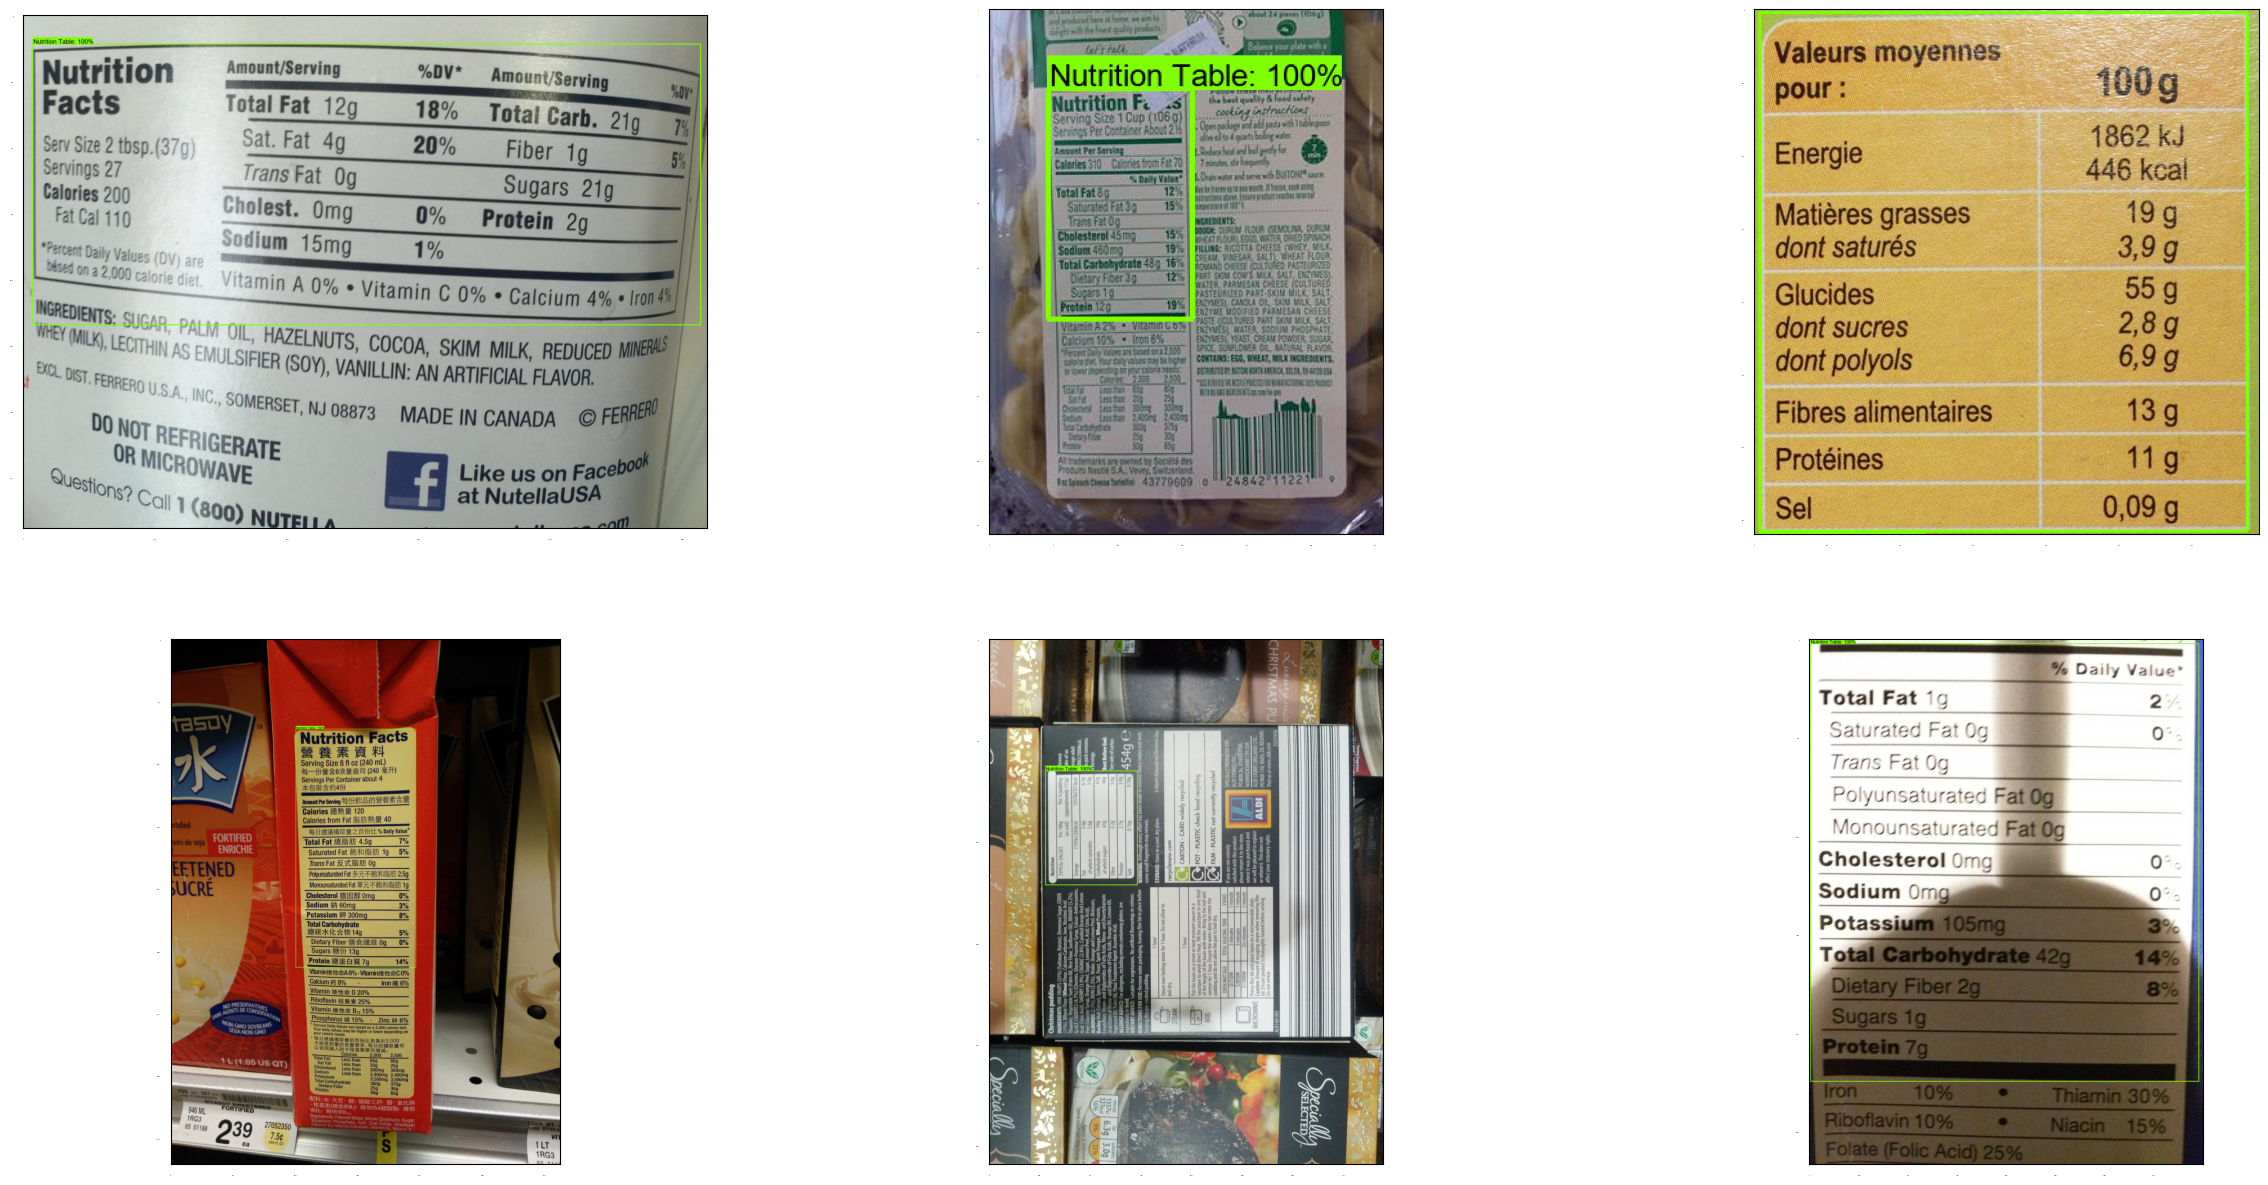

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  gt_boxes_np = np.array(gt_boxes[idx])
  plot_detections(
      train_images_np[idx],
      gt_boxes_np,
      np.ones(shape=[gt_boxes_np.shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## 8. Building a Pretrained SSD Resnet50 FPN Model and Fine Tuning

In [17]:
# Download the pre-trained model SSD ResNet50 V1 FPN 640x640 from TensorFlow Model Zoo
!curl -OL http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!move ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

^C


ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001: truncated gzip input: No such file or directory
tar: Error exit delayed from previous errors.
Access is denied.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  233M    0 29028    0     0  17834      0  3:48:47  0:00:01  3:48:46 17852
  0  233M    0  235k    0     0  92373      0  0:44:10  0:00:02  0:44:08 92442
  0  233M    0  425k    0     0   116k      0  0:34:05  0:00:03  0:34:02  116k
  0  233M    0  634k    0     0   137k      0  0:28:58  0:00:04  0:28:54  137k
  0  233M    0  848k    0     0   151k      0  0:26:17  0:00:05  0:26:12  170k
  0  233M    0 1164k    0     0   176k      0  0:22:35  0:00:06  0:22:29  228k
  0  233M    0 1499k    0     0   197k      0  0:20:11  0:00:07  0:20:04  253k
  0  233M    0 1685k    0     0   195k      0  0:20:20  0:00:08  0:20:12  253k
  0  233M    0 1882k    0     0   195k      0  0:20

In [26]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed..
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Get the ground truth
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


c:\Users\Azhar\anaconda3\envs\tf_gpu_win\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 100, loss=1.4235972


batch 10 of 100, loss=0.33325985
batch 20 of 100, loss=0.15358329
batch 30 of 100, loss=0.11375885
batch 40 of 100, loss=0.0821714
batch 50 of 100, loss=0.03544583
batch 60 of 100, loss=0.03370287
batch 70 of 100, loss=0.045235217
batch 80 of 100, loss=0.034061156
batch 90 of 100, loss=0.020249248
Done fine-tuning!


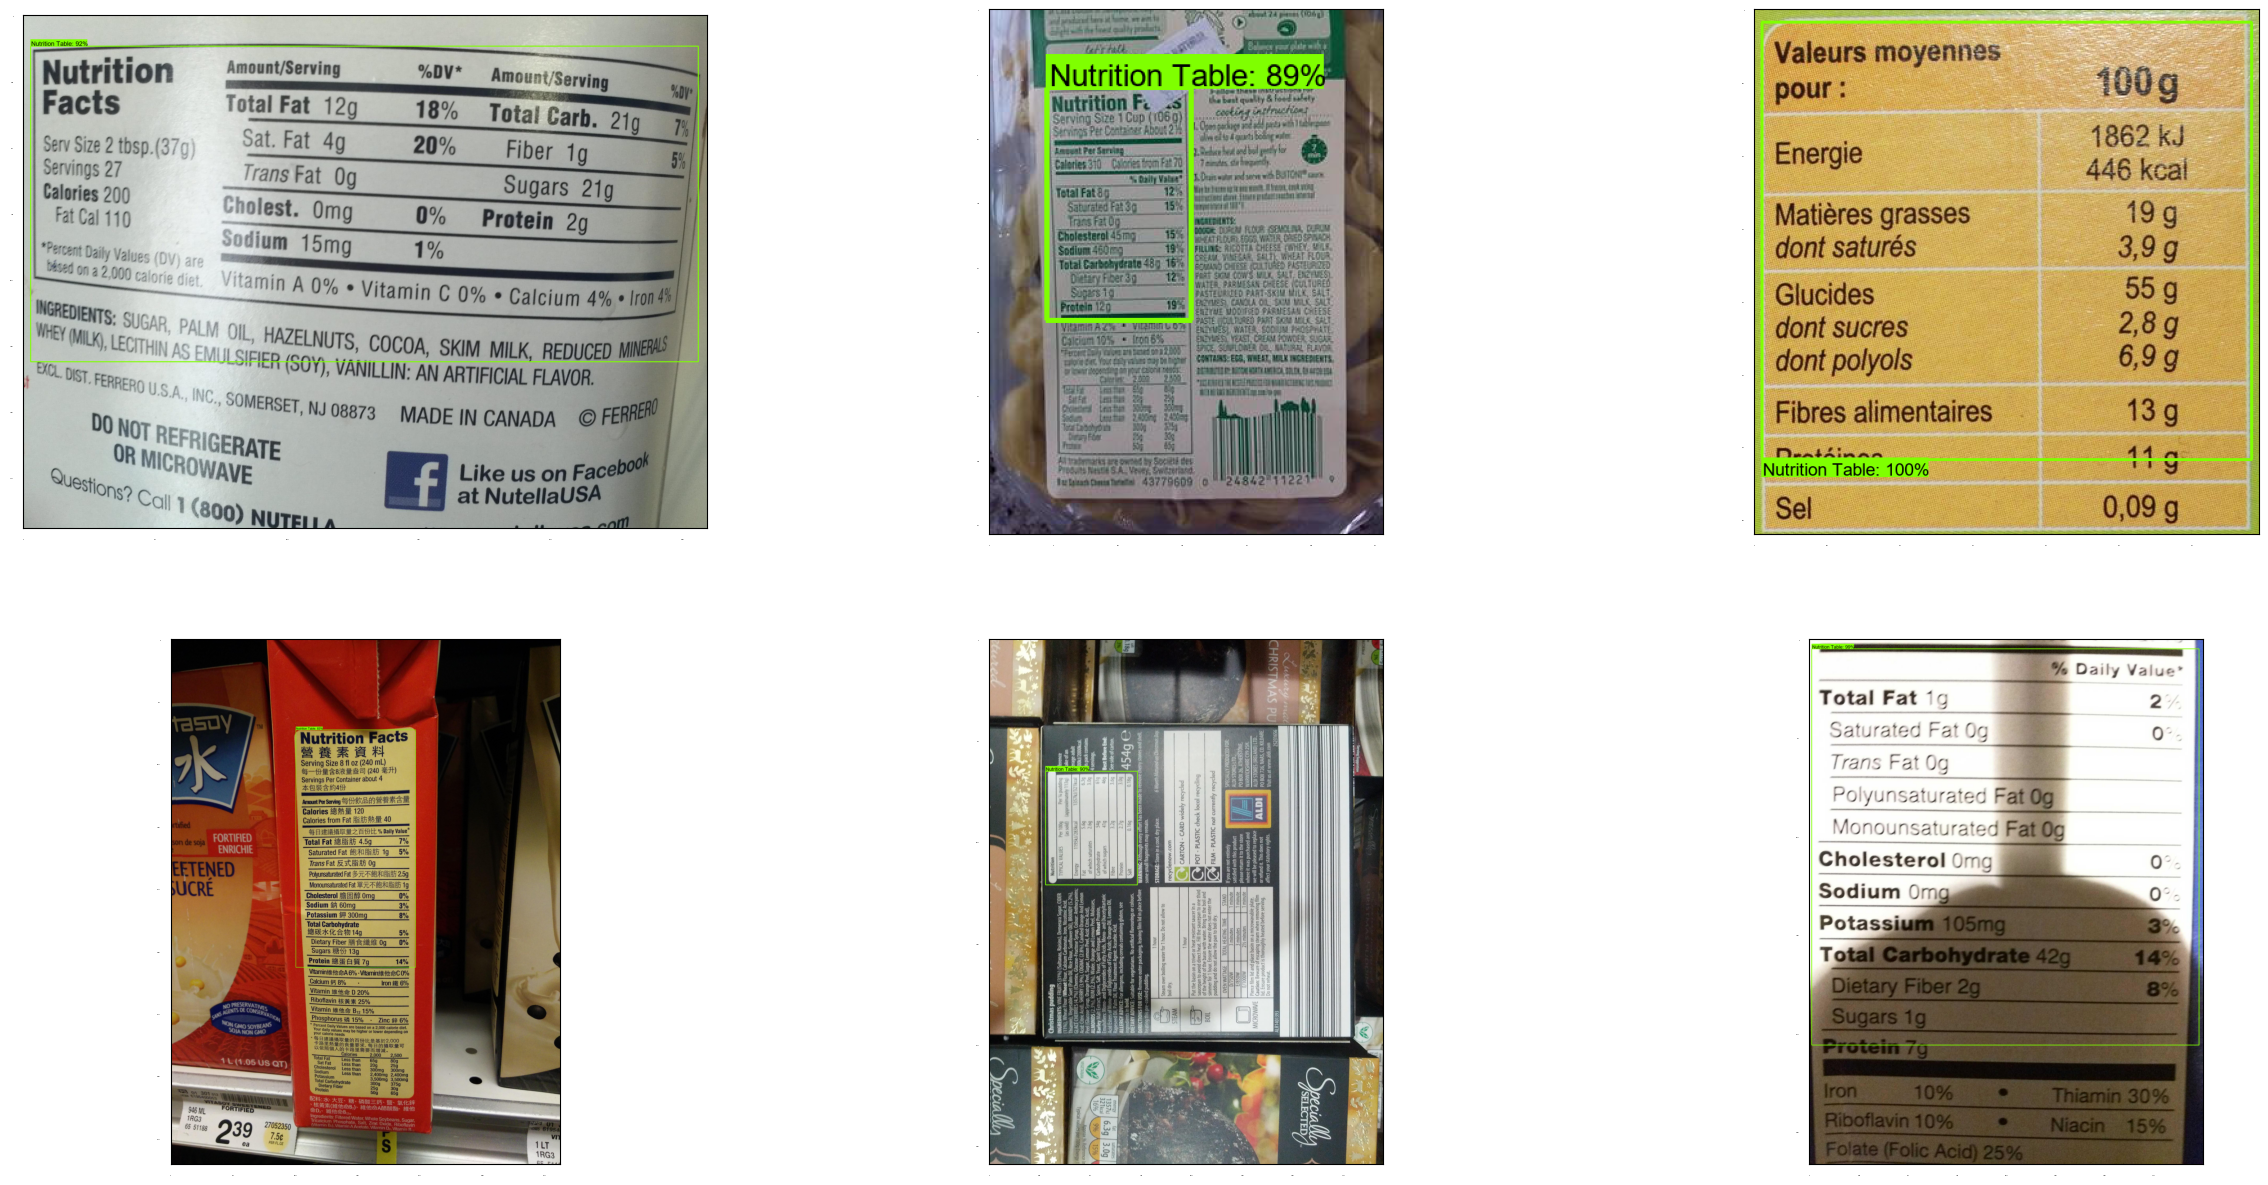

In [29]:


# Display 6 images with their predictions
plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx + 1)
  image_np = train_images_np[idx]
  input_tensor = tf.convert_to_tensor(image_np[tf.newaxis, ...], dtype=tf.float32)
  detections = detection_model(input_tensor)
  plot_detections(
    image_np,
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index
  )
plt.show()

In [30]:
# Save the model
tf.saved_model.save(detection_model, 'fine_tuned_model')

INFO:tensorflow:Assets written to: fine_tuned_model\assets


INFO:tensorflow:Assets written to: fine_tuned_model\assets
